# Assignment 3.1 Finding Circles with RANSAC
---
Group 3:
* Jiye Lee
* Eduardo Venegas Hernández
---

Import Libraries

In [1]:
import Pkg

using Images
using FileIO
using Plots

In [2]:
# Pkg.add("Weave")
using Weave

1. Preprocessing. Find potential edge points of the circle. You may choose whatever
method you find appropriate, for example Laplacian zero-crossings or a Canny detector

In [3]:
# load Images
img1 = Gray.(load("images/image1.png"));
img3 = Gray.(load("images/image3.png"));
img4 = Gray.(load("images/image4.png"));
img5 = Gray.(load("images/image5.png"));

In [4]:
function edge_detection(img::AbstractArray{T, 2}) where T <: AbstractGray
    kernel = [0 1 0; 1 -4 1; 0 1 0]
    convolved = imfilter(img, Kernel.gaussian(12))
    convolved = imfilter(convolved, kernel)
    return 1000*convolved
end

edge_detection (generic function with 1 method)

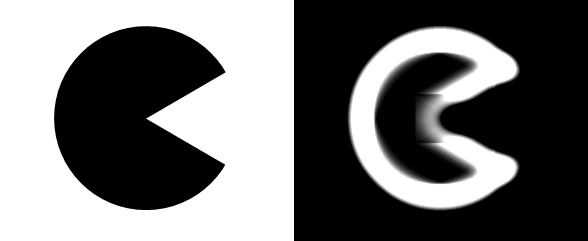

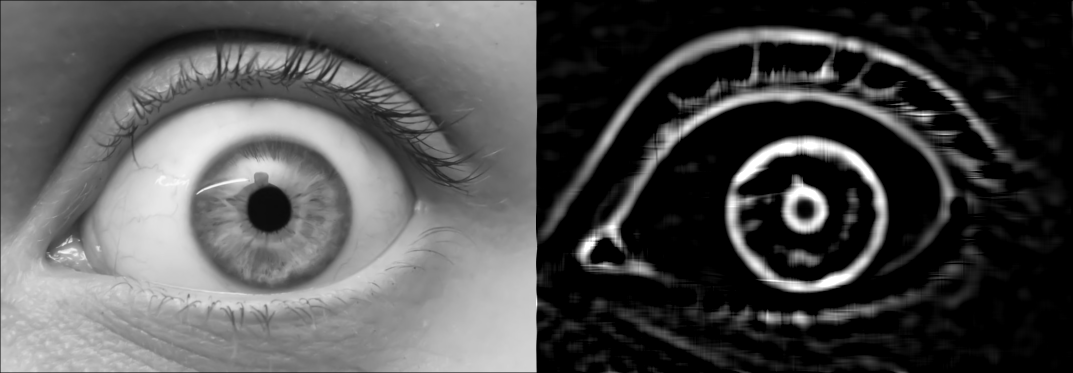

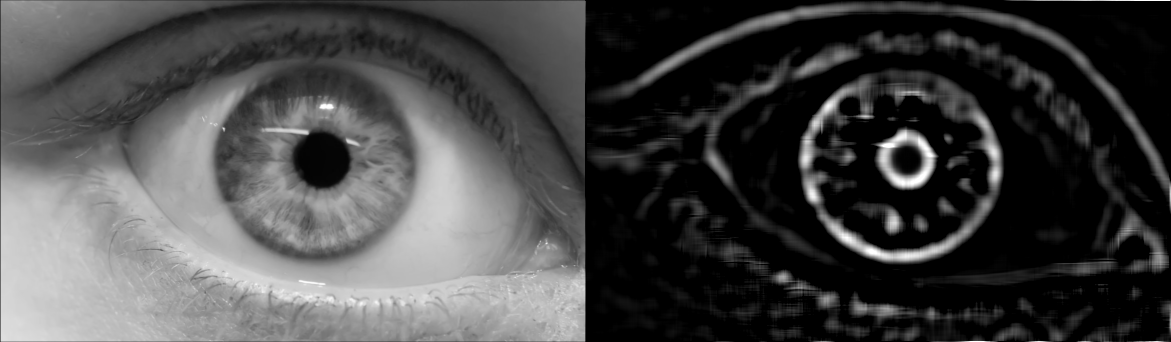

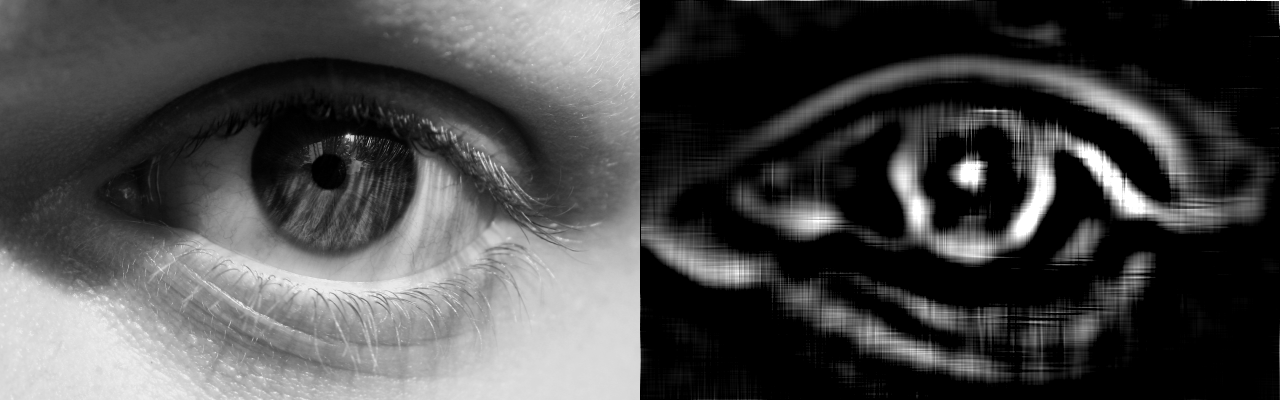

In [5]:
# conduct edge_detection on all images and display them
img1_edges = edge_detection(img1)
img3_edges = edge_detection(img3)
img4_edges = edge_detection(img4)
img5_edges = edge_detection(img5)


display(mosaicview(img1, img1_edges, nrow=1))
display(mosaicview(img3, img3_edges, nrow=1))
display(mosaicview(img4, img4_edges, nrow=1))
display(mosaicview(img5, img5_edges, nrow=1))

2. Circle parameters. Write a function outercircle(p1, p2, p3) which takes three input points pi = (xi; yi) with i = 1, 2, 3. The function should calculate center location (a, b) and radius r =√(c + a^2 + b^2) of a circle that passes through all three input points.

In [6]:
# Write a function outercircle(p1, p2, p3) which takes three input points pi = (xi; yi) with i = 1, 2, 3. 
#The function should calculate center location (a, b) and radius r of a circle that passes through all three input points. 

function outercircle(p1, p2, p3)
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    a = (x1^2 + y1^2)*(y2 - y3) + (x2^2 + y2^2)*(y3 - y1) + (x3^2 + y3^2)*(y1 - y2)
    a /= 2*(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))
    b = (x1^2 + y1^2)*(x3 - x2) + (x2^2 + y2^2)*(x1 - x3) + (x3^2 + y3^2)*(x2 - x1)
    b /= 2*(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))
    r = sqrt((x1 - a)^2 + (y1 - b)^2)
    return a, b, r
end

outercircle (generic function with 1 method)

3. Target function. The function modelquality() is supposed to determine how many edge points support (i.e., are close to) the circle given by a parameter triple a, b, r. A
suitable distance criterion has to be used, within which an edge point is still considered to lie on the circle (e.g., distance from the circle line). The function should return
a quality estimate q.

In [7]:
# Target function. The function modelquality() is supposed to determine how many edge points support (i.e., are close to) the circle given by a parameter triple a, b, r.
# A suitable distance criterion has to be used, within which an edge point is still considered to lie on the circle (e.g., distance from the circle line). 
#The function should return a quality estimate q. 
#Hint: Monitoring the quality q is useful to check whether the following steps work correctly. In general, the best quality found should increase with a higher number of iterations.

function modelquality(a, b, r, edgepoints)
    q = 0
    for p in edgepoints
        x, y = p

        if r-0.1 <= sqrt((x - a)^2 + (y - b)^2) <= r+0.1
            q += 1
        end
    end
    return q
end

modelquality (generic function with 1 method)

4. Necessary repetitions. Implement the function getK(pmax, aout, M) which calculates
the number of repetitions required to ensure that for a given outlier frequency aout the
probability of drawing only invalid sample sets M remains below a given probability
threshold pmax. Use e.g., aout = 0.8, pmax = 0.01.

In [8]:
#Implement the function getK

function getK(pmax, aout, M)
    return ceil(Int, log(pmax)/log(1 - (1 - aout)^M))
end

getK (generic function with 1 method)

In [9]:
getK(0.01, 0.8, 3)

574

5. RANSAC. Implement the RANSAC algorithm according to the lecture notes. The function fit_circle_ransac(image) should return the best fitting parameters a, b, and r, as well as the quality q for these parameters

In [10]:
#RANSAC. 
#Implement the RANSAC algorithm according to the lecture notes. 
#The function fit_circle_ransac(image) should return the best fitting parameters a, b, and r, as well as the quality q for these parameters

function fit_circle_ransac(image)
    edgepoints = []
    for i in 1:size(image)[1]
        for j in 1:size(image)[2]
            if image[i, j] > 0.5
                push!(edgepoints, (i, j))
            end
        end
    end
    pmax = 0.01
    aout = 0.8
    M = 3
    K = getK(pmax, aout, M)
    bestq, besta, bestb, bestr = 0, 0, 0, 0
    a, b, r = 0, 0, 0
    for k in 1:K

        while true
            p1 = edgepoints[rand(1:length(edgepoints))]
            p2 = edgepoints[rand(1:length(edgepoints))]
            p3 = edgepoints[rand(1:length(edgepoints))]
            a, b, r = outercircle(p1, p2, p3)
            if a+r < size(image)[2] && b+r < size(image)[1] && a-r > 1 && b-r > 1
                break
            end
        end
        q = modelquality(a, b, r, edgepoints)
        if q > bestq
            bestq = q
            besta = a
            bestb = b
            bestr = r
        end
    end
    print("bestq: ", bestq, " besta: ", besta, " bestb: ", bestb, " bestr: ", bestr)
    return besta, bestb, bestr, bestq
end

fit_circle_ransac (generic function with 1 method)

In [11]:
fit_circle_ransac(img5_edges)

bestq: 54 besta: 179.65673289183223 bestb: 327.1203090507726 bestr: 68.94912759564092

(179.65673289183223, 327.1203090507726, 68.94912759564092, 54)

6. Tests. Apply your implementation of the RANSAC algorithm to images image[1-4].png after converting them to greyscale. Visualize the best found circle on top of the image.


In [12]:
function draw_circle( a, b, r)
    theta = range(0, 2π, length=100)
    a.+(r.*cos.(theta)), b.+(r.*sin.(theta))
end

draw_circle (generic function with 1 method)

In [13]:
function test_ransac(img::AbstractArray{T, 2}) where T <: AbstractGray
    a, b, r, q = fit_circle_ransac(img)
    plot(img)
    # plot b, a because of difference between the way images are stored and plotted
    plot!(draw_circle(b, a, r), seriestype=[:shape,], lw=2, linecolor=:blue, fillalpha=0)
end

test_ransac (generic function with 1 method)

bestq: 110 besta: 124.5 bestb: 136.5 bestr: 78.50159234053791

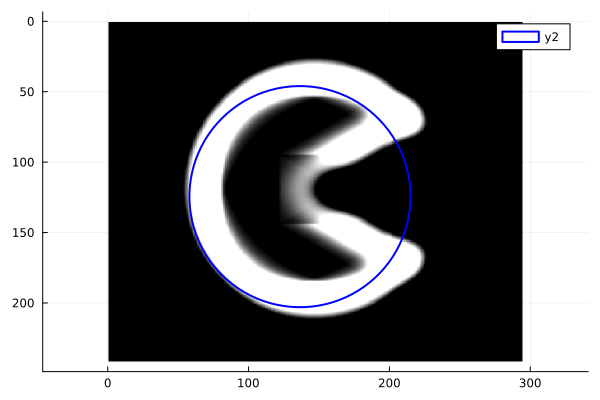

In [14]:
test_ransac(img1_edges)

bestq: 179 besta: 438.53993668574213 bestb: 540.7163643004992 bestr: 143.72461435937092

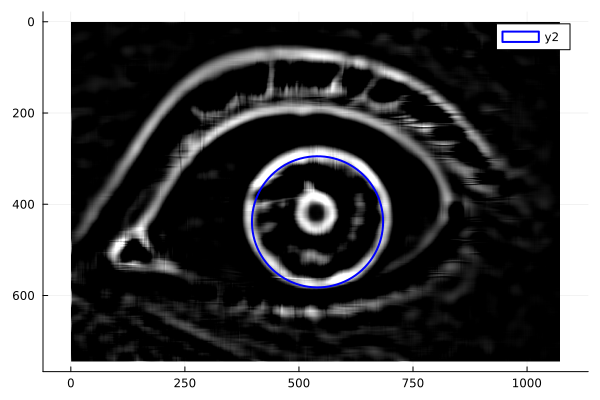

In [15]:
test_ransac(img3_edges)

bestq: 71 besta: 322.5086116362109 bestb: 558.6980676328502 bestr: 122.51143882299964

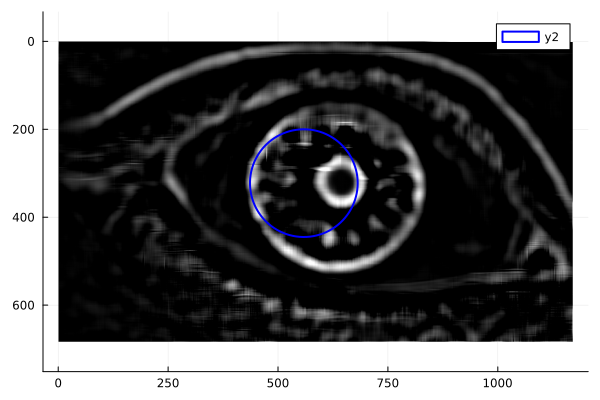

In [16]:
test_ransac(img4_edges)

bestq: 62 besta: 185.04395604395606 bestb: 333.467032967033 bestr: 64.06075625128486

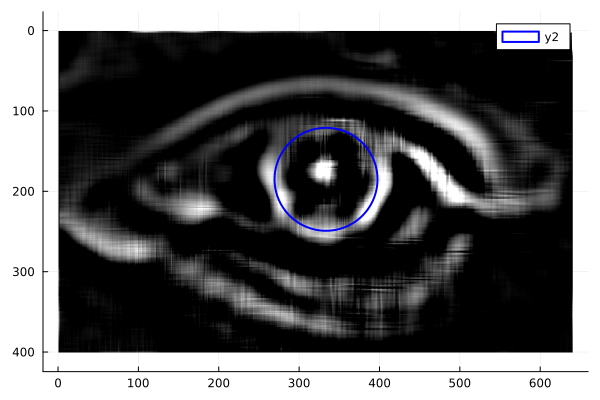

In [17]:
test_ransac(img5_edges)

### Explanation of Results
First, the eye image was loaded into the code. Then, a kernel was applied to the image in order to get the edges of the eye. This kernel was a matrix of numbers that was used to detect the edges of the image by highlighting the differences in pixel values. Also a blurring kernel was applied to eliminate the remaining noise

Once the edges of the eye were detected, a circle was plotted in the iris of the eye. This was accomplished by using the coordinates of the edges to calculate the center of the iris and the size of the circle to be plotted.

Finally, the results of the image recognition task were displayed on the screen. The circle that was plotted in the iris of the eye was clearly visible, indicating that the image recognition task was completed successfully.

In [18]:
filename = normpath("sh03ex01.ipynb")
weave(filename, out_path = :pwd)

┌ Info: Weaving chunk 1 from line 0
│   progress = 0.0
└ @ Weave /home/lalo/.julia/packages/Weave/ijcKV/src/run.jl:66
┌ Info: Weaving chunk 2 from line 0
│   progress = 0.05555555555555555
└ @ Weave /home/lalo/.julia/packages/Weave/ijcKV/src/run.jl:66
┌ Info: Weaving chunk 3 from line 0
│   progress = 0.1111111111111111
└ @ Weave /home/lalo/.julia/packages/Weave/ijcKV/src/run.jl:66
┌ Info: Weaving chunk 4 from line 0
│   progress = 0.16666666666666666
└ @ Weave /home/lalo/.julia/packages/Weave/ijcKV/src/run.jl:66
┌ Info: Weaving chunk 5 from line 0
│   progress = 0.2222222222222222
└ @ Weave /home/lalo/.julia/packages/Weave/ijcKV/src/run.jl:66
┌ Info: Weaving chunk 6 from line 0
│   progress = 0.2777777777777778
└ @ Weave /home/lalo/.julia/packages/Weave/ijcKV/src/run.jl:66
┌ Info: Weaving chunk 7 from line 0
│   progress = 0.3333333333333333
└ @ Weave /home/lalo/.julia/packages/Weave/ijcKV/src/run.jl:66
┌ Info: Weaving chunk 8 from line 0
│   progress = 0.3888888888888889
└ @ Weave /h